<a href="https://colab.research.google.com/github/arronelab/makeMolecules/blob/main/notebook/MakeMolecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Clone Repo and Compile { display-mode: "form" }

#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left.
%cd /content/
%shell rm -rf makeMolecules
!git clone https://github.com/arronelab/makeMolecules.git makeMolecules
%cd makeMolecules/
%shell sh makeFileFinalPrediction.sh

/content
Cloning into 'makeMolecules'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 132 (delta 28), reused 113 (delta 20), pack-reused 0
Receiving objects: 100% (132/132), 1.54 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/makeMolecules


In [9]:
#@title Install Requirements { display-mode: "form" }

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.
!pip install Bio

import urllib.request
import os
import sys
import re
import json
import numpy as np
import pandas as pd
import ast
from Bio import PDB, SeqIO
from Bio.SeqUtils import seq1 
from google.colab import files
import matplotlib.pyplot as plt

In [5]:
#@title Config File { display-mode: "form" }
#@markdown  First, choose a project name.
test_name = "test" #@param {type:"string"}
#@markdown Next, set the number of changes from the initial structure. This is changes to the whole structure, that is if you choose to make just one change, each atom that will be changed once, not just one atom.
number_changes = 1 #@param {type:"integer"}
#@markdown Finally, set the number of times you'd like to perform the test.  This is the number of output files you will get.
number_outputs =  4#@param {type:"integer"}
#@markdown Once you have set the parameters above, press the *Play* button on the left to make your config file.

def write_sh_file(project_name,fit_steps,no_mols,
                  preprocessed_data_dir = "newFitData/human_SMARCAL1",
                  fingerprint_path = "newFitData/human_SMARCAL1/fingerPrint.dat", 
                  coords_path = "newFitData/human_SMARCAL1/coordinates.dat", 
                  contacts_path = None, 
                  fixed_sections_path = None                 
                  ):
    """Writes the config shell script based on parameters given by the user on data upload.

    Args:
        project_name (str): [description]
        preprocessed_data_dir (str): [description]
        fingerprint_path (str): [description]
        coords_path (str, optional): [description]. Defaults to None.
        contacts_path (str, optional): [description]. Defaults to None.
        fixed_sections_path (str, optional): [description]. Defaults to None.
        fit_steps (int, optional): [description]. Defaults to 1000.

    Returns:
        output_filepath (str): path to the finished shell script
    """
    output_filepath = project_name + '_config.sh'
    output_dir = os.path.join(preprocessed_data_dir,project_name)
    with open(output_filepath, 'w+') as fout:
      fout.write('#!/bin/bash')
      fout.write('\nSequenceFile={}'.format(fingerprint_path))
      if coords_path is not None:
        fout.write('\ninitialCoordsFile={}'.format(coords_path))
      else:
        fout.write('\ninitialCoordsFile=none')
      if contacts_path is not None:
          fout.write('\npairedPredictions={}'.format(contacts_path))
      else:
          fout.write('\npairedPredictions=none')
      if fixed_sections_path is not None:
          fout.write('\nfixedsections={}'.format(fixed_sections_path))
      else:
          fout.write('\nfixedsections=none')
        # no options for crystal symmetry or or hydro cover in prototype
      fout.write('\ncrystalSymmetry=none')
      fout.write('\nwithinMonomerHydroCover=none')
      fout.write('\nbetweenMonomerHydroCover=none')
      fout.write('\nmaxNoFitSteps={}'.format(str(fit_steps)))
      fout.write('\n\nif [ ! -d {} ]; then'.format(output_dir))
      fout.write('\n  mkdir -p {};'.format(output_dir))
      fout.write('\nfi')
      fout.write('\n\nfor i in {1..'+str(no_mols)+'}')
      fout.write('\ndo')
      fout.write('\n    /content/makeMolecules/predictStructure $SequenceFile '
    	'$initialCoordsFile $pairedPredictions $fixedsections $crystalSymmetry '
    	'$withinMonomerHydroCover $betweenMonomerHydroCover '
    	'$maxNoFitSteps /content/makeMolecules/{}/mol$i.dat'.format(output_dir))
      fout.write('\ndone')
    return output_filepath

if __name__ == "__main__":
    write_sh_file(project_name=test_name,fit_steps=number_changes,no_mols=number_outputs)
    

In [ ]:
#@title Make Molecules { display-mode: "form" }

#@markdown Please execute this cell by pressing the *Play* button on 
#@markdown the left. Your outputs will be in a folder with your chosen test name, inside the newFitData/human_SMARCAL1 tree.
outputs_dir = '/content/makeMolecules/newFitData/human_SMARCAL1/'+test_name
!bash {test_name}_config.sh


In [ ]:
#@title Download Outputs { display-mode: "form" }

#@markdown Press the *Play* button if you'd like to download your outputs in a
#@markdown zip file.
%cd /content/makeMolecules/newFitData/human_SMARCAL1/
!zip -q -r {outputs_dir}.zip {test_name}
files.download(f'{outputs_dir}.zip')
%cd /content/makeMolecules/

None


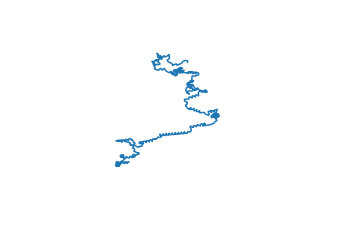

In [46]:
#@title View Molecules
def set_axes_radius(ax, origin, radius):
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])


def set_axes_equal(ax, zoom=1.):
    '''
        Make axes of 3D plot have equal scale so that spheres appear as spheres,
        cubes as cubes, etc..  This is one possible solution to Matplotlib's
        ax.set_aspect("equal") and ax.axis("equal") not working for 3D.
        input:
          ax:   a matplotlib axis, e.g., as output from plt.gca().

    '''
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0])) / zoom
    set_axes_radius(ax, origin, radius)

def view_molecule(molecule):
    file = open(molecule) 
    lst = []
    for line in file:
        lst += [line.split()]
    file.close()
    for i in range(len(lst)-1):
        if lst[i]:
          for j in range(3):
            lst[i][j] = float(lst[i][j])
    mol = [i for i in lst[:-1] if i]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = [mol[i][0] for i in range(len(mol))]
    ys = [mol[i][1] for i in range(len(mol))]
    zs = [mol[i][2] for i in range(len(mol))]
    ax.plot(xs,ys,zs)
    set_axes_equal(ax)
    ax.grid(False)
    ax.view_init(elev=20.,azim=-70)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.axis('off')

print(view_molecule('/content/makeMolecules/newFitData/human_SMARCAL1/test/mol1.dat'))